# Signálový model systému

Signálový model popisuje postup generovania meranej diskrétnej veličiny  $z_k$ na základe vnútorného stavu systému $x_k$, externého riadenia $u_k$ a náhodná premenná $v_k$, index $k$ určuje časový okamžik. Veličiny $z_k$, $x_k$ a $u_k$ sú vo všeobecnosti vektory, pričom ich veľkosti nemusia byť rovnaké. 

Grafická reprezentácia modelu je na obrázku

<img src="img/model_02.png" width="600">

Veličiny popisujúce signálový model:

- $G_k$ je transformačná matica, ktorá definuje konverziu medzi vektorom riadenia a stavovým vektorom (napr. výkon motora a zrýchlenie vozidla). Riadiaci vektor $u_k$ nemusí byť rozmerovo zhodný so stavovým vektorom $x_k$, niektorý element riadiaceho vektora môže vplývať na niekoľko stavových parametrov a pod. 


- $H_k$ je transformačná matica, ktorá definuje vzťah medzi stavovým vektorom a meranými veličinami (napr. zrýchlenie vozidla a hodnota akcelerometra). Merané veličiny nemusia byť zhodné so stavovým vektorom, niektoré stavové parametre môžu byť priamo nemerateľné alebo skryté.


- $F_k$ je systémová matica, popisujúca prechod stavu systému pri zmene časového okamžiku $k \rightarrow k+1$


- $v_k$ je náhodná premenná s nulovou strednou hodnotou, ktorá určuje varianciu generovanej hodnoty  $z_k$


- $\Delta_t$ je jednotkové časové oneskorenie, definuje časový interval medzi stavmi $k$ a $k+1$


Rovnice stavového popisu (<i>state-space equations</i>) systému sú 

\begin{equation}
x_{k+1} = F_k \,  x_{k} + G_k u_{k} 
\end{equation}

\begin{equation}
z_k = H_k \, x_{k} + v_{k}
\end{equation}



In [1]:
%reset -f  
%matplotlib inline
import matplotlib.pylab as plt
from numpy import arange, array, dot
from numpy.random import randn

### Implementácia modelu

Implementácia modelu je samozrejme závislá od konkrétneho účelu. Ukážeme si použitie modelu pre generovanie simulovaných výstupov senzorov polohy, rýchlosti a zrýchlenia umiestnené na pohybujúcom sa vozidle. V programovej implementácii požadujeme, aby riadiacim vektorom modelu bola veličina úmerná impulzu sily pôsobiacej na vozidlo (sila a doby jej pôsobenia) a výstupnými vektormi boli vektor nameraných hodnôt s aditívnym šumom a vektor ideálnych hodnôt senzorov bez šumu - polohy, rýchlosti a zrýchlenia.

Implementácia signálového modelu je vo funkcii <i>motionData</i>, ktorej vstupné  parametre sú uvedené v tabuľke:


 <table style="width:80%" >
  <tr>
    <th>Parameter</th>
    <th>Popis</th>
    <th>Jednotky</th>
    <th>Formát</th>
  </tr>
    
  <tr>
    <td>t</td>
    <td>vektor časových intervalov</td>
    <td>[s]</td>
    <td>$[\Delta_1, \Delta_2, \dots \Delta_n]$</td>
  </tr>
  
  <tr>
    <td>f</td>
    <td>vektor pôsobiacich síl</td>
    <td>[N]</td>
    <td>$[f_1, f_2, \dots f_n]$ </td>
  </tr>
  
  <tr>
    <td>std </td>
    <td>vektor štandardných odchýlok </td>
    <td>$[m, \, m s^{-1}, \, m s^{-2}]$ </td>
    <td>$[\sigma_1, \sigma_2, \sigma_3]$ </td>
  </tr>
  
  <tr>
    <td>m </td>
    <td>hmotnosť vozidla </td>
    <td>[kg] </td>
    <td>$m$ </td>
  </tr>
  
  <tr>
    <td>dt </td>
    <td>interval vzorkovania </td>
    <td>[s] </td>
    <td>$\Delta_t$ </td>
  </tr>
  
</table>

In [2]:
def motionData(t, f, std = [0.02, 0.02, 0.05], m=100., dt=0.1):
 
    x=[0., 0., 0.]              # state vector [s, v, a]  
      
    F=[[1.0,  dt, dt*dt/2],
       [0.0, 1.0,      dt],
       [0.0, 0.0,     0.0]]     # ! F[3,3] - control value   
        
    u=[0.0]                     # control vector    
    
    G=[[0.0],                   # control matrix
       [0.0],
       [1./m]]                  # substitute for F[3,3] 
             
    H=[[1.0, 0.0, 0.0],
       [0.0, 1.0, 0.0],
       [0.0, 0.0, 1.0]]
    
    zr = [] 
    xr = []                # return values

    for i in range(len(t)):
        u=[f[i]]
        for j in arange(0, t[i], dt):
            z = dot(H,x) + std*randn(3)    # x(k)
            zr.append(z)
            xr.append(x)
            x = dot(F, x) + dot(G,u)       # x(k+1)

    return array(zr), array(xr), arange(0, sum(t),dt)

### Príklad použitia modelu

Potrebujeme vygenerovať dáta pre simuláciu pohybu vozidla o hmotnosti 100kg, na ktoré pôsobí po dobu 1s sila +20N (zrýchluje), 1s sa pohybuje bez pôsobenia sily rovnomerným pohybom a po dobu 1s pôsobením sily -20N spomalí a zastaví.

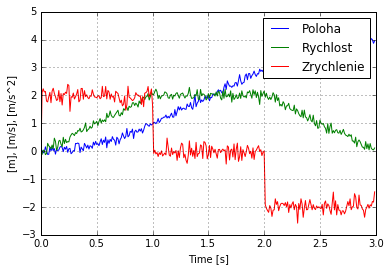

In [3]:
t = [ 1.0, 1.0,   1.0]     # time intervals
f = [200.0, 0.0, -200.0]     # force

std = [0.1, 0.1, 0.2]   # standard deviations
m = 100                    # weigth
dt = 0.01                  # sampling interval

z, _, tm = motionData(t, f, std, m, dt)
plt.plot(tm, z[:,0], label='Poloha')
plt.plot(tm, z[:,1], label='Rychlost')
plt.plot(tm, z[:,2], label='Zrychlenie')
plt.xlabel('Time [s]')
plt.ylabel('[m], [m/s], [m/s^2]')
plt.grid()
plt.legend()
plt.show()